<h1><center>Tutorial on A/B Testing</center></h1>

<h2>Jupyter Notebook</h2>

Jupyter notebooks can be very handy as it helps in combining code with the text. We can create presentations, or technical documents using notebook. Default jupyter notebook can be difficult to work with, particularly when large document with a lot of sections and subsections. Or even codes become difficult to read if the code includes lots of functions, loops etc.

If you use jupyter notebook, please install the extension: nbextension. <a href="https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/install.html">check here for installations</a>

After you install the extension, a new option will come up as shown Figure 1 (a). Click on it to and select the extension you want in your notebook as I have selected some in Figure 1(b). Once clicked, you can use those extensions.


<img src="notebook.png" width="1000">

In [7]:
# loading all the requisite libraries that will be required for the toy model
import scipy.stats as st
from scipy.stats import beta,norm,binom
import matplotlib.pyplot as mplt
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import math


<h2>Whats in this tutorial</h2>

In this tutorial we will go through the basic of A/B testing. We assume that you have an understanding of the why A/B testing is done. This tutorial guides through an example to the steps involved in A-B testing. Topics included are: <br>
 <br>
<b>
1. Recap of Probability Distributions <br>
2. Defining Metrics and Understanding their Properties <br>
3. Running A/B tests <br>
</b>

A/B testing is a general methodology used online when we want to test new products or features. A/B test allows us to determine <b>scientifically how to optimize products or features</b> (a website or an app or any system) by trying out possible changes and see what performs better with your users. It allows to make <b>data-driven decisions</b> rather than relying on intution about user preferences. To keep the discussion concise, hereafter, we will explain A/B testing as a method employed to determine if a new feature F2 should replace existing feature F1. This feature could be a small change (e.g. changing the font or color of a button on your website) or a complicated change (using deep learning for product recommendation in amazon). This feature could not even be user visible (changing the ranking system of friend suggestion in facebook).  

Broadly speaking, A/B testing uses two sets of users. First set, the <b>control group</b>, is shown Feature F1 and the second set, <b>treatment group/ experiment group</b> is shown the new feature F2. A/B testing uses rigorous post experiment analysis to  to determine which feature performs better with users. A/B testing is generally used when we compare two options. If more than 2 options (of features) are tested, it is called multi-variate A/B testing (or split test). A brief explanation of A/B testing is shown in Figure 1 where a company wants to increase its user engagement.

<img src="AB.jpg" width="800">
<center>Figure 1. An example of A/B testing and split test</center>

<h2>Recap of Probability Distributions</h2>

A probability distribution is a function that describes the likelihood of obtaining the possible values that a random variable can assume. In other words, it is the histogram with very small bins of random variable (s). Figure below shows how the histogram changes as we increase the number of samples. For simplicity, lets consider that these random draws have been obtained from normal distribution and binomial distribution. Therefore, as more and more samples are being drawn, the histogram of random variables look like the distribution from which it was drawn from.

<h3>Normal distribution</h3>

In [8]:
@interact( samples = (100,100000,5000), bins=(10,100,10))  #start point, end point, jump size
def normal_draw( samples=100, bins=10):
    ground_truth = np.random.normal(0,1,samples)
    mplt.hist(ground_truth,bins=bins);

interactive(children=(IntSlider(value=100, description='samples', max=100000, min=100, step=5000), IntSlider(v…

<h3>binomial distribution</h3>

In [9]:
@interact( samples = (100,100000,5000), bins=(10,100,10)) 
def binomial_draw( samples=100, bins=10):
    ground_truth = np.random.binomial(100,0.3,samples)
    mplt.hist(ground_truth,bins=bins);

interactive(children=(IntSlider(value=100, description='samples', max=100000, min=100, step=5000), IntSlider(v…

Binomial distribution can be approximated as normal distribution (when the sample size is large enough) with mean $np$ and standard deviation $np(1-p)$. As it can be seen in the figure above, as sample size increase, the distribution looks very similar to the normal distribution.

<h3>Difference between two distribution</h3>

Suppose we want to find out if we can differentiate between two distributions. If we have two distribution, we can check if we can observe the difference between them or not. We can use t test to check the difference. Let distribution 1 be the known distribution, and distribution 2 be the samples collected. We want to check if the difference of $mu$ can be observed or not.

In [10]:
@interact(mu=(0.1,1,0.05),std=(0.5,10,0.5),samples=(100,1000,50))  #start point, end point, jump size
def normal_draw(mu=-2,std=1,samples=100):
    
    # this is the known distribution, we dont change this
    # distribution with mean = 0 and std = 1
    x  = np.linspace(norm.ppf(0.01,0,1),norm.ppf(0.99,0,1), 100)
    rv = norm(0, 1)
    mplt.plot(x, rv.pdf(x), 'k-', lw=2,c='orange',label='prob distribution')
    mplt.axvline(x=0,c='orange')                            
    
    x  = np.linspace(norm.ppf(0.01,mu,std),norm.ppf(0.99,mu,std), 100)
    rv = norm(mu,std)
    mplt.plot(x, rv.pdf(x), 'k-', lw=2,c='blue',label='samples')
    mplt.axvline(x=mu,c='blue') 
    mplt.legend();
    
    print('performing t test')
    distribution1 = np.random.normal(0,1,1000)
    distribution2 = np.random.normal(mu,std,samples)
    print(st.ttest_ind(distribution1,distribution2))

interactive(children=(FloatSlider(value=0.1, description='mu', max=1.0, min=0.1, step=0.05), FloatSlider(value…

<u>Observe the following</u>: <br>
1) as the difference (mu) increases, t statistic increases: we <b>can</b> differentiate between the two distributions better<br>
2) as the spread (std) increases, t statistic decreases: we <b>cannot</b> differentiate between the two distributions better<br>
3) as the samples (n) increases, t statistic increases: we <b>can</b> differentiate between the two distributions better<br>


We will use these factors in determining how to do reliable A-B testing.

<h2>Defining Metrics and Understanding their Properties</h2>

It is very critical to understand how we select our metrics for the test as it will define the success of the A/B tests.

<h3>Metrics should make business sense</h3>

The most important property of the metrics is that it should satisfy business needs and add some values to the company. It could be economic value e.g. increase in user clicks or it could also be done for understanding user behavior. The managers should know what are they going to use the metrics for. The metrics should be well defined, that is, there should be no confusion on what formula is to be used for calculating the metric (click through rate is different from number of clicks/views). The developers should be able to measure the metrics in short time. For example, sign up does not tell if the the user is going to refer or not. As mentioned before, the metrics should not take long time to measure (e.g. effect of a soap on skin cancer). The company should have complete information about the metric. We should be able to measure the metric (is it mean, median) and understand possible error in collecting the metrics (e.g. if click through rate increase by 30%, there might be a bug in the code in collecting the data).

Using the current system, check the values and distribution (or collect all statistics) for the metrics. These statistics are called baseline values. Ensure that these baseline values makes sense and there is no bug in collecting this data.

<h3>Filtering</h3>

We should be able to identify issues while collecting these metrics. For example, we <b>should check how the data is collected </b> (e.g. check that there is no spam) that is affecting our data collection and we should be able to filter these. Users in control and treatment group should not know if they have been placed in one of the groups (it affects the randomization of the experiment and users might self-select to either join or leave the experiment). Also, users should not know that an experiment is being carried out. This might affect the metrics as users in control group would want to test the new feature if they know about it and this might pollute the current experiment.


<h3>Invariance check</h3>

Before running the experiment and analyzing the results, A/B testing should go through sanity checks for randomization. <b>The distribution of user characteristics in control and treatment groups should be the same</b>. This can also be done by A/A testing. That is instead of sending the new feature F2 to the treatment group, just send feature F1. As the user groups are randomly created, there should be no difference in user engagement between both the groups.

<h3>Sensitivity and Robustness</h3>

The metrics should be <b>sensitive enough to move if there is an actual difference in the response in control and the treatment group</b>. but it should not be very sensitive that a slight change would result in a very different measures. Thus, the <b>metric should be robust to changes</b>. For example, if our metric is mean of total donations, mean is sensitive to outliers. If our metric is median, it is robust to outliers but it might be very </b>insensitive</b>. For example, if just 1% of users buy a product, and we use median, the median might not move and it will 0 in both the groups.

Before selecting the metrics, a histogram of the metric for the existing users should be used to identify the nature of metrics. Different metrics include mean, median, percentiles, ratios, or percent change. Percent change is insensitive to changes in absolute values (which is desirable in many situations). <b>A/A test might also be able to test too sensitive metrics as the metrics will be different only because the users are different</b>

<h3>Variability</h3>

Variability or variance is critical for analyzing the results of A/B testing as we use confidence intervals and hypothesis testing for detecting the change. Metrics may follow different distributions. <b>For calculating the confidence interval and analyzing the results, we should know about the distribution of the metrics</b> and how to calculate the variability. Estimating variance may not always be easy (e.g. median of a non-normal distribution or a complex distribution) when analytical result for variance calculation is not possible.

If the variance cannot be calculated variance analytically, we can <b>calculate it empirically</b>. Variability calculation makes an underlying assumption that we know the inherent distribution of the metric. When it is complex, we can run a lot of small A/A tests to identify the underlying distribution of the metrics. Or we can do one big A/A test and use techniques like bootstrapping (sampling with replacement) to get the underlying distribution of the metrics.

<h3>Randomization</h3>

Randomization is also very important in conducting A/B tests. 
<ul>
    <li>Users should not know if they are in experiment (may not be possible always) and particularly they should never know if they are in treatment group or control group</li>
    <li>Assignment of users should not change during the experiment. For example, if a user is in control group at the start of the experiment, they should not see/get the features of treatment group (or be re assigned to treatment group) </li>
    <li>Users should not know about the experiment (treatments). For example, if one user (treatment group) discusses new feature on their app, and other users (in control group) dont see that feature, their behavior might change. Although its not possible to be able to do this for all apps/companies, the experiments can be achieved by doing it in 2 cities (controlling for inter-city differences)</li>
    <li>Random experiments should not be known to the users beforehand. For example, if an app is testing a new language feature that they will introduce a local language and they want to check if it increases uninstalls, it will not be a clean experiment if they announce/advertise that they are launching a new language feature -- the users may expect langauge in their app and if they dont see it, they might uninstall.</li>
    <li>Assignment of users to different groups should be completely random. For example, if users are assigned based on operating system (android vs iOS), it will lead to wrong inference as iphone users (more expensive than android phones) might purchase more. Or it will give wrong results if some of the feature doesnt work in iOS but works in android (or different browsers)</li>
</ul>
        

<h3>Duration of the Experiment</h3>
    
    
The duration of A/B testing also determines if A/B testing should be done. Too short a duration gives unreliable results while running it too long could be expensive. Also, if we run A/B testing for long, users might "learn" the changes in feature. This will make the test unreliable. 

<h2>Designing the Experiment </h2>

Now that we understand what metric we will be using for our A/B testing, we need to design the experiment. Studies should be designed in collaboration with the designers. Designing the experiment includes the following:

1. Selecting the subject
2. Selecting the population for control and treatment group
3. Sample size needed to run the experiment and duration of the experiment

<h3>Selecting the subject</h3>

It is important to define how we <b>define our subjects</b>. If we do not consider subjects and randomize, same user may see F1 and F2 on two different occasions. Thus, it is important to <b>ensure that a user sees only one of the options</b>. For example, in a mobile app, email id of the user can be selected as the unique identifier for a user. But how do we collect data for users who have not signedup for the app? If we just consider the users who have signedup, we will be biasing our data for "better customers". If we use web cookies to identify a user, what happens if the user uses multiple devices and we get a different id for the same user? 

Assigning only <b>one feature to one user during the experiment is called consistency</b> (a user should always see the same feature they were assigned, every time they use the website/app). The variable that provides a unique id to the a subject is called <b>unit of diversion</b>. When we measure metric, the denominator is called <b>unit of analysis</b>. For example, if we consider a webpage, and our metric is the number of clicks/user, user is the unit of analysis (also, the diversion is user as we count the total number of clicks for unique user). Variability of the metric can also be affected by the diversion we select. If the unit of analysis is the same as the unit of diversion, <b>metric variability</b> is lower when they aren't same.

<h3>Selecting the population</h3>

The most important criteria for A/B testing is <b>randomization</b>. The population in the control group and the treatment group should have similar properties (the more similar the better). For example, if the average age of users in control group is higher than that of the treatment group (and we younger people use their phones more), the results will be biased and it will overestimate the effect of F2. 

There are some techniques called <b>intra-users</b>. In these techniques, the same user is exposed to both the features (thus the population property is exactly the same for both the control and treatment). However, it is risky. For example, the order in which the features were exposed to the user might have an effect on user response. For example, if users liked the first feature and not like the second feature, they may leave the app. Thus, it is better to use inter-users (or standard A/B test with a control and the treatment group).

In <b>medical trials</b>, to maintain the similarity of population, cohorts are selected. In best case scenario, two very similar users (patients) can be selected with similar demographics and medical history and paired together (send one to control group and one to the treatment group). In nature vs nurture debate, two identical twins were the best sample for the study as their nature (conditions under which they were born) was exactly the same. Online experiments do not have the luxury to know about the users.

While selecting the population, the users <b>should not anticipate the new features</b>. There should be no cross sharing of information. For example, if it is widely known that a company has added a new feature, some users will be frustrated if they wanted that feature and they were kept in the control group (media attention should be avoided). In many research studies, the researchers (and anyone involved in the project) do not participate in the project as they know what to expect from the new feature.

<h2>Sample size calculation </h2>

How long the A/B tests should be continued? A/B testing should be done for metrics that can be observed in short time. However, the sample size (or data collected from A/B testing) should be enough for us to confidently accept/reject the results from A/B testing. This Section uses the knowledge we used in Section on Recap of Probability Distribution (sample size, difference between the two distributions, standard deviation of the distribution) First we discuss <b>p-value</b> and <b>significance levels</b>.

In hypothesis testing, null hypothesis states the world we believe exists. Null hypothesis is the baseline in A/B testing (e.g. No difference in user engagement between control group and treatment group). Alternative hypothesis looks into our interest of difference (e.g. user engagement increases or not by using F2). <b>p-value</b> is the probability that the world we believe exists. For example, if p-value is 0.02, it says, there is a 2% chance that the world of null hypothesis exists. If p-value is smaller than the level of significance, we reject the null hypothesis, assuming we observed it by chance (2% chance in this case). Thus, <b>significance level</b> is the probability of rejecting the null hypothesis when it is true. Generally the level of significance is kept at 5%.

In A/B testing, we compare two samples. We expect the two samples to behave differently (if we expect the feature to have an impact). Thus the standard error would be different for the two samples. Thus we use pooled standard error (<i>p-SE</i>). Let <i>d</i> be the difference (of probability of click) between the two groups. If our null hypothesis says there is no difference between the two groups, we expect <i>d = 0</i>. We can calculate the confidence interval, centered around 0 with margin of error by using <i>p-SE</i>. If <i>d</i> lies on either side of the extreme of the confidence interval (smaller than left side or larger than right side), we reject the null hypothesis as unlikely and say the difference between the two samples is <b>statistically significant</b>.

In hypothesis testing, we might fall into two errors. In <b>Type-I</b> error, or alpha, we reject null hypothesis given it is true. In <b>Type-II</b> error, or beta, we fail to reject the null hypothesis, given it is false. They are also called producer's risk and consumer's risk respectively. Type-II error can be more serious (e.g. testing that a drug works and giving it to patients given that the medicine doesn't actually work). The power of test is defined as 1-beta, that is the probability to reject the null hypothesis when it is false. Hypothesis testing is based on the assumption that we know how many samples were needed to be collected to detect the change we wanted to see. But in practice, it is other way round, that is, we first collect data and then do the hypothesis testing. Some companies just do do a one shot testing after collecting the data, but they keep on continuing the experiment such that the results dont change much over time (e.g. AirBnB).

<h3>Sample size Theory</h3>

Sample size depends on the desired power of the test and desired level of change we want to detect in the two groups (control and treatment). This <b>level of change we want to detect is called minimum detectable effect (MDE)</b>. For <b>higher power of the test, we need larger sample size</b>. <b>The smaller the change we want to detect, the larger sample size we need</b>. For example, in medicine, we might want to detect if the change in using a drug is 5% - 10%. In click through rate on advertisement, we might want to detect even a 2% change. In medical field, if the change is not large enough, it will practically insignificant to implement the changes (as it will be very expensive to train nurses, inform doctors about new drug and send the new medicines to pharmaceuticals). The change we want to detect is called practically significant change. Thus, A/B testing results should detect practically and also statistically significant changes. The relation between these is explained below in Figure 3.

Left part of Figure 3 shows what does power of a test graphically. As the sample size increases, the standard error decreases, thus the distribution become tighter and tighter. As seen from the figure, the chances of wrongfully concluding that no difference exists (even though difference exists) decreases. Also, as the distributions move away from each other (if there is larger difference), the power of the test is high as it can easily detect the change. Thus, it becomes difficult to detect smaller changes. Thus power increases on increasing the sample size. Power is kept at 80% generally.

Check the online calculator (by optimizely) used for calculating the sample size.
https://www.optimizely.com/sample-size-calculator/

<img src="Power.jpg" width="900">
<center>Calculating the Power of a test. $p_1$ and $p_2$ show the mean of the two distribution (this figure shows the sample size of binomial distribution but it can be generalized to any distribution). It should be beta and NOT beta/2</center>

<h3>Sample size calculation Example</h3>

We will use the concepts from Section 3 and the previous section to find an estimation of the number of samples we need to collect to observe a desired difference (MDE) that should make business sense. For example, if the click through rate in general is 3% and we set out to detect a click through rate of 10%, we might not be able to detect that level of change. However, we will miss out on potential 2% gain in click through rate (if the new click through rate is 5%) as our experiment will show <b>insignificant changes</b> if we want to detect a 7% increase in click through rate.


Therefore, we should have a prior knowledge of the metric we are looking to improve through A/B testing. For example, lets take an example of click through rate. Since it is a probability, we can use binomial distribution. Let $p=0.1$ (click through rate of 10%), variance equals $p(1-p)$ = 0.09.

In [11]:
# calculator for the sample size (size may depend if beta is one sided or two sided, here I considered two sided)
# change the different parameters to see how the sample size changes
# baseline is set as p
# p: baseline probability (from domain knowledge), delta: change we want to detect, # power: power of the test

@interact( p = (0.05,0.7,0.05), delta=(0.01,0.09,0.01), power=(0.6,0.95,0.05))
def posterior( p=0.05, delta=0.025,power=0.6):
    z_alpha = st.norm.ppf(1-0.05/2)    # significance level = 0.05
    z_beta  = st.norm.ppf(power)
    print('p:',p,'delta value:',delta, 'power value:',power)
    var_p = p*(1-p)
    size = 2*int(var_p*math.pow(z_alpha+z_beta,2)/math.pow(delta*p,2))
    print("sample size:", size)

interactive(children=(FloatSlider(value=0.05, description='p', max=0.7, min=0.05, step=0.05), FloatSlider(valu…

<u>Observations</u> <br>
<ul>
    <li>As p increases (up to 0.5), sample size required increases (as variance is maximum at p = 0.5)</li>
    <li>As delta increases, sample size decreases (as two distributions move far). Thus we should select a reasonable value for delta. If delta value is too high, it will show that the experiment requires only 100 samples (and in that 100 samples, the variance might be too high and the experiment would imply: no significant difference between control and treatment)</li>
    <li>As power-of-test requirement increase, sample size increases (to be more precise and confident)</li>
</ul>

<h2>Analyzing Results </h2>

Once we define the metrics, set up the experiments and get the data from the experiment, we are ready to analyze the results. using the analysis, we want to conclude the results of the experiment. Analyzing the results rigorously is critical as the based on the conclusion, the change would be implemented.

<h3>Stopping the experiment</h3>

In A/B testing, the experiment can be stopped under two condition. One, when enough data points have been collected. Second when the results are statistically significant. Based on the analysis of the results, managers can decide if they want to continue the experiments or not (if the difference is practically significant). It also depends on the manager as how long they want to continue (till they are completely confident in the results).

<h3>Sanity Checks</h3>

A/B testing is an iterative process. Based on checks and learnings from these sanity checks, we need to redesign the experiments. Check if the data captured is correct (looks reasonable). For example, there is no drastic or incomprehensible changes in the metrics. We also need to <b>check the metrics of the two groups before we run the experiment</b>.

Another important sanity check is to <b>check the other metrics</b>. We can use A/A test to check the invariance in metrics between the two groups. We also need to check that other metrics (which should not change on changing the features under study) remain <b>invariant, or there is no significant change between the two groups</b>. They might change if they are highly correlated with the evaluation metric. If sanity checks fail, do not proceed with the analysis.

<h2>Example</h2>

We use data from Kaggle <a href="https://www.kaggle.com/yufengsui/mobile-games-ab-testing">here</a>. Its a data on mobile game retention (a user does not uninstall the app). 1 day retention = user comes back to use the app one day after installing the app. 7 day retention = user comes back to use the app 7 days after uninstalling. We can start with analyzing the data.

In [16]:
data = pd.read_csv("./cookie_cats/cookie_cats.csv")

In [18]:
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


control        = gate_30 in column: version <br>
treatment      = gate_40 in column: version <br>
sum_gamerounds = number of games a user played in first 14 days after installing the app

<h3>Data Exploration</h3>

In [19]:
print(data['version'].value_counts())
print("NOTE:Number of users in control and treatment group are similar")

version
gate_40    45489
gate_30    44700
Name: count, dtype: int64
NOTE:Number of users in control and treatment group are similar


In [20]:
print(data['retention_1'].value_counts())

retention_1
False    50036
True     40153
Name: count, dtype: int64


In [21]:
print(data['retention_7'].value_counts())

retention_7
False    73408
True     16781
Name: count, dtype: int64


Box plot shows that there is one outlier, we can filter now but outliers should be investigated as why such a big number is observed


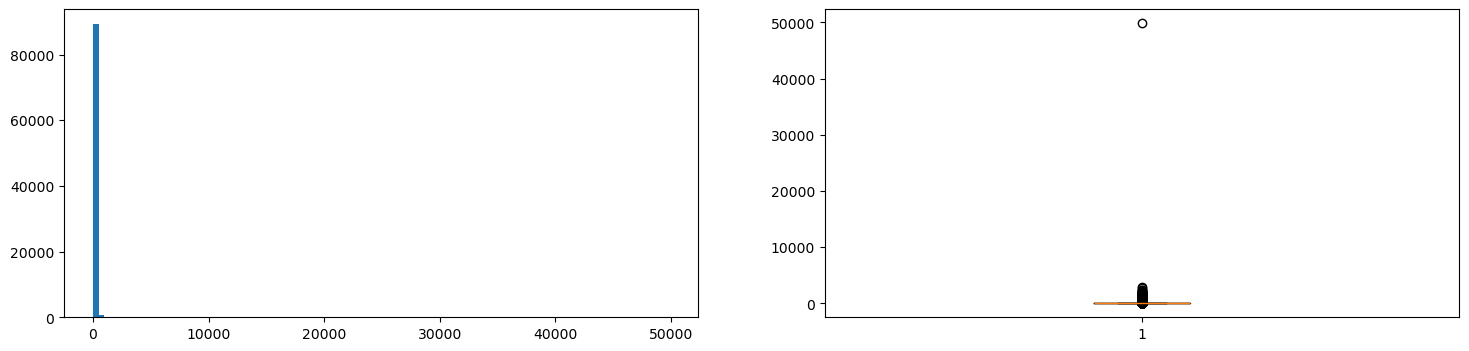

In [22]:
fig = mplt.figure(figsize=(18,4))
mplt.subplot(1,2,1)
mplt.hist(data['sum_gamerounds'],bins=100);

mplt.subplot(1,2,2)
mplt.boxplot(data['sum_gamerounds']);

print("Box plot shows that there is one outlier, we can filter now but outliers should be investigated as why such a big number is observed")

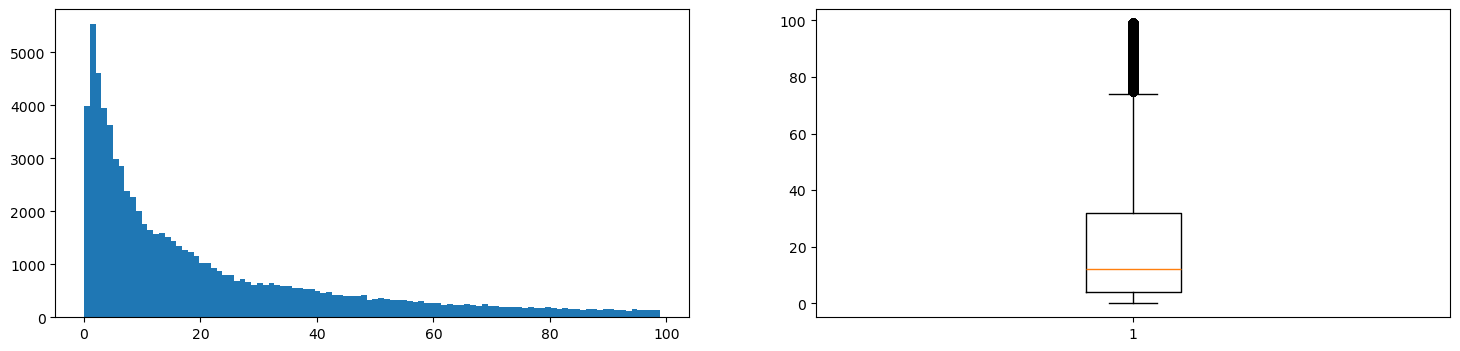

In [23]:
# filtering the data
# assuming that user have played at max 100 games (to ensure we are colleting data from legitimate data and not bots)
data = data[data['sum_gamerounds']<100]

fig = mplt.figure(figsize=(18,4))
mplt.subplot(1,2,1)
mplt.hist(data['sum_gamerounds'],bins=100);

mplt.subplot(1,2,2)
mplt.boxplot(data['sum_gamerounds']);

# note that there are gaps in the histogram of the columns sum_gamerouds: this could be an error and should be checked.

<h3>A/A Testing</h3>

We first use data for the 10,000 users from control group for our A/A testing and building the prior (getting an idea of the probability of uninstalls)

In [24]:
# first collecting the data for A/A testing from the control group 
# for that, randomize the data and collect first 10,000 users data for the control group
# then split these 10,000 users into two groups of 5000 randomly

# random seed is to get the same results everytime the code is run
np.random.seed(0)


# shuffle randomly
data_random  = data[data['version']=='gate_30'].sample(frac=1).reset_index(drop=True)

# shuffle again (not really required here as we have already shuffled but for the sake of randomization)
random_index = np.random.permutation(10000)
data_A1     = data_random.iloc[random_index[0:5000]]
data_A2     = data_random.iloc[random_index[5000:10000]]

# we make sure that these users are not selected for our A/B testing as we have already seen their data
# to make the sample size for A/B approximately similar, we can remove first 10,000 users from treatement group as well
data_control = data_random.iloc[10000:]
data_treatment = data[data['version']=='gate_40'].sample(frac=1).reset_index(drop=True).iloc[10000:]

data_A1.shape,data_A2.shape,data_control.shape, data_treatment.shape

((5000, 5), (5000, 5), (28532, 5), (29141, 5))

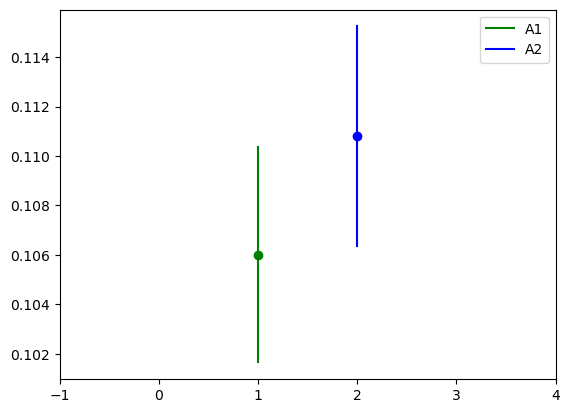

In [25]:
# check the probability of uninstalls (we consider day 7 retention as our metric in this case) fro A/A testing
p_A1 = data_A1['retention_7'].value_counts().values[1]/len(data_A1)
p_A2 = data_A2['retention_7'].value_counts().values[1]/len(data_A2)

# We can use normal approximation for calculating the confidence interval  
ll_A1,ul_A1 = p_A1-np.sqrt((p_A1*(1-p_A1))/len(data_A1)),p_A1+np.sqrt((p_A1*(1-p_A1))/len(data_A1))
ll_A2,ul_A2 = p_A2-np.sqrt((p_A2*(1-p_A2))/len(data_A2)),p_A2+np.sqrt((p_A2*(1-p_A2))/len(data_A2))

mplt.plot([1,1],[ll_A1,ul_A1],color='green',label='A1')
mplt.plot([2,2],[ll_A2,ul_A2],color='blue', label='A2')
mplt.scatter([1],[p_A1],color='green')
mplt.scatter([2],[p_A2],color='blue')
mplt.legend();
mplt.xlim(-1,4);

<u>Observation</u> <br>
We can observe that the confidence intervals intersect. So statistically, there is no difference between the two groups in A/A testing. This is a good sanity check to perform and check if the data is collected correctly. We can also draw the distribution of 'sum_gameround' to check if the distribution across the two groups in similar. 


The following figure also illustrates that we should keep a track of other metrics as well and they should still make sense.

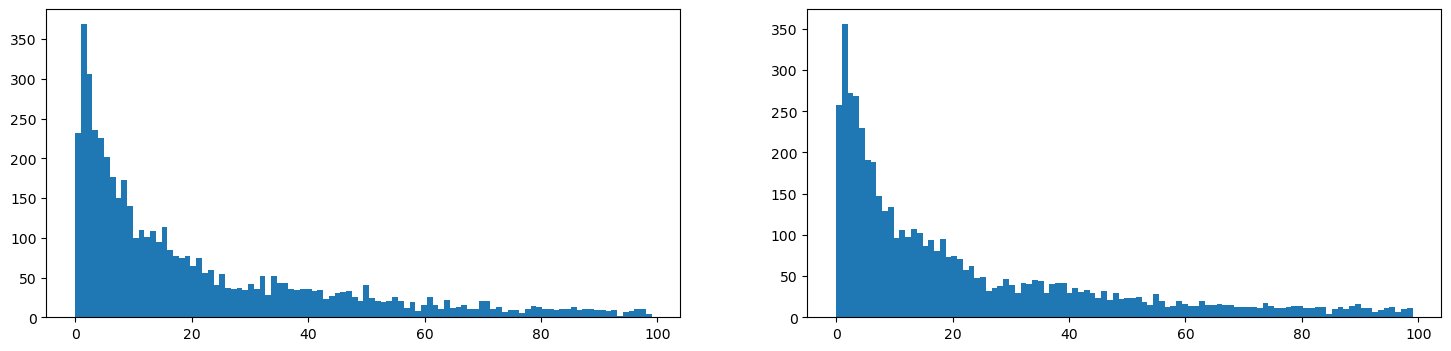

In [26]:
fig = mplt.figure(figsize=(18,4))
mplt.subplot(1,2,1)
mplt.hist(data_A1['sum_gamerounds'],bins=100);

mplt.subplot(1,2,2)
mplt.hist(data_A2['sum_gamerounds'],bins=100);

In [27]:
# collecting data for the prior distribution
# this is the retention rate in the app (we can collect more than 10,000 user to build prior, these are subjective questions)
# and they can be answered best by people with domain knowledge in the company
np.random.seed(0)

data_prior  = data[data['version']=='gate_30'].sample(frac=1).reset_index(drop=True).iloc[0:10000]
p_prior     = data_prior['retention_7'].value_counts().values[1]/len(data_prior)

p_prior

0.1084

<h3>A/B testing</h3>

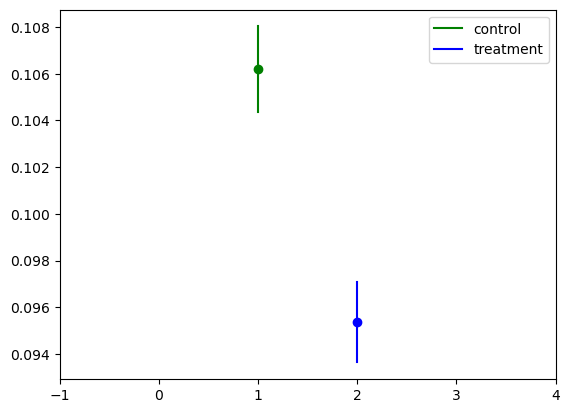

In [28]:
# check the probability of uninstalls (we consider day 7 retention as our metric in this case) fro A/A testing
p_control = data_control['retention_7'].value_counts().values[1]/len(data_control)
p_treatment = data_treatment['retention_7'].value_counts().values[1]/len(data_treatment)

# We can use normal approximation for calculating the confidence interval  
ll_control,ul_control = p_control-np.sqrt((p_control*(1-p_control))/len(data_control)),p_control+np.sqrt((p_control*(1-p_control))/len(data_control))
ll_treatment,ul_treatment = p_treatment-np.sqrt((p_treatment*(1-p_treatment))/len(data_treatment)),p_treatment+np.sqrt((p_treatment*(1-p_treatment))/len(data_treatment))

mplt.plot([1,1],[ll_control,ul_control],color='green',label='control')
mplt.plot([2,2],[ll_treatment,ul_treatment],color='blue', label='treatment')
mplt.scatter([1],[p_control],color='green')
mplt.scatter([2],[p_treatment],color='blue')
mplt.legend();
mplt.xlim(-1,4);

<u>Observation</u> <br>
We can observe that the 7 day retention for the control group (gate_30) is higher than the treatment group (and statistically different too). Thus, we can say that it is better to keep gate_30 rather than gate_40 if the company wants higher retention. NOTE that the results have been obtained based on some filtering we did earlier. Results might change based on how we use the filter and all these analysis should be done before presenting the final conclusion.

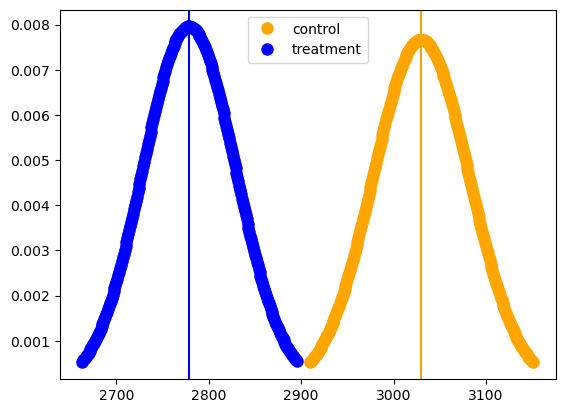

In [29]:
n  = len(data_control)
p  = data_control['retention_7'].value_counts().values[1]/n
x = np.arange(binom.ppf(0.01, n, p),binom.ppf(0.99, n, p))
mplt.plot(x, binom.pmf(x, n, p), 'o', ms=8, label='control',color='orange')
mplt.axvline(x=n*p,c='orange')                            

n  = len(data_treatment)
p  = data_treatment['retention_7'].value_counts().values[1]/n
x = np.arange(binom.ppf(0.01, n, p),binom.ppf(0.99, n, p))
mplt.plot(x, binom.pmf(x, n, p), 'o', ms=8, label='treatment',color='blue')
mplt.axvline(x=n*p,c='blue') 
mplt.legend();


In [30]:
def trueFalse(x):
    if 'True' in str(x):
        c = 1
    else:
        c = 0
    return(c)
print('performing t test')
distribution1 = data_control['retention_7'].apply(lambda x:trueFalse(x))
distribution2 = data_treatment['retention_7'].apply(lambda x:trueFalse(x))
print(st.ttest_ind(distribution1,distribution2))

performing t test
TtestResult(statistic=4.322327443910718, pvalue=1.5465013030125073e-05, df=57671.0)


<u>Observation</u> <br>
p value < 0.05 shows that the the performance of gate_30 and gate_40 (control and treatment) is significantly (statistically) different. Since retention is lower for gate_40, gate_30 (control) should be continued and gate_40 (treatment) should not be introduced. This also shows that A/B testing may not always be improving the system, they might make the system worse.

<h3>sample size</h3>

After we finish the first run, we observe that the treatment group performs worse than the control group and thus gate_40 should not be introduced in the app. However, was the sample size big enough? Our analysis considered around 27000 samples for each group. We can check sample size based on what difference we would like to observe. We will use p_prior as our baseline probability.

Result below show that we do NOT have enough samples in our data to observe a 1% difference between the metric in control and treatment group. We can detect not lower than 5% change. However, if we want to detect a 1% change in the performance, we should collect more data. Thus before rejecting the treatment, more samples are to be calculated.

In [31]:
@interact(delta=(0.01,0.1,0.001), power=(0.6,0.95,0.05))
def posterior(delta=0.01,power=0.6):
    p = p_prior
    z_alpha = st.norm.ppf(1-0.05/2)    # significance level = 0.05
    z_beta  = st.norm.ppf(power/2)
    print('p:',p,'\ndelta value:',delta, 'power value:',power)
    var_p = p*(1-p)
    size = 2*int(var_p*math.pow(z_alpha+z_beta,2)/math.pow(delta*p,2))
    print("\nsample size:", size)

interactive(children=(FloatSlider(value=0.01, description='delta', max=0.1, min=0.01, step=0.001), FloatSlider…

<h2>More on When to Stop A/B Testing</h2>

It is important to understand when should we stop the experiment (or for how long the A/B testing be continued to collect enough data). <b>We checked the p-value at the end of the data collection</b>. It is a common mistake to stop the experiment too soon and make wrong decision. However, conducting the experiments can be expensive. The method of using p-value for identifying if the treatment performs good or not assumes we know the sample size and effect we want to check ($\delta$). Sometimes, we dont know how much $\delta$ we can gain from the feature we are testing. For example, if $\delta$ of 0.2% can be observed, but we are only interested in 2%, our experiments will never be significant (which may cause loss of 0.2% potential gain). However, as more data is collected, and continuously check the p-value, we may observe fluctuating p-value and we are likely to see an effect, even if there is none. So when should we stop?

<img src="airBnB.png" width="800">
<center>Image from AirBnB (<a href="https://medium.com/airbnb-engineering/experiments-at-airbnb-e2db3abf39e7">here</a>)</center>

In [32]:
# We can also check out test for continuous monitoring
# We can plot p-value after every 1000 data points.

def trueFalse(x):
    if 'True' in str(x):
        c = 1
    else:
        c = 0
    return(c)

distribution1 = data_control['retention_7'].apply(lambda x:trueFalse(x))
distribution2 = data_treatment['retention_7'].apply(lambda x:trueFalse(x))

p_value = []
p_A1    = []
p_A2    = []

# we obtain values 28 times (every 1000)
for t in range(28):
    p_value.append(st.ttest_ind(distribution1.iloc[0:1000*(t)],distribution2.iloc[0:1000*(t)])[1])
    p_A1.append(np.mean(distribution1.iloc[0:1000*(t)]))
    p_A2.append(np.mean(distribution2.iloc[0:1000*(t)]))

Text(0.5, 0, 'number of data points x 1000')

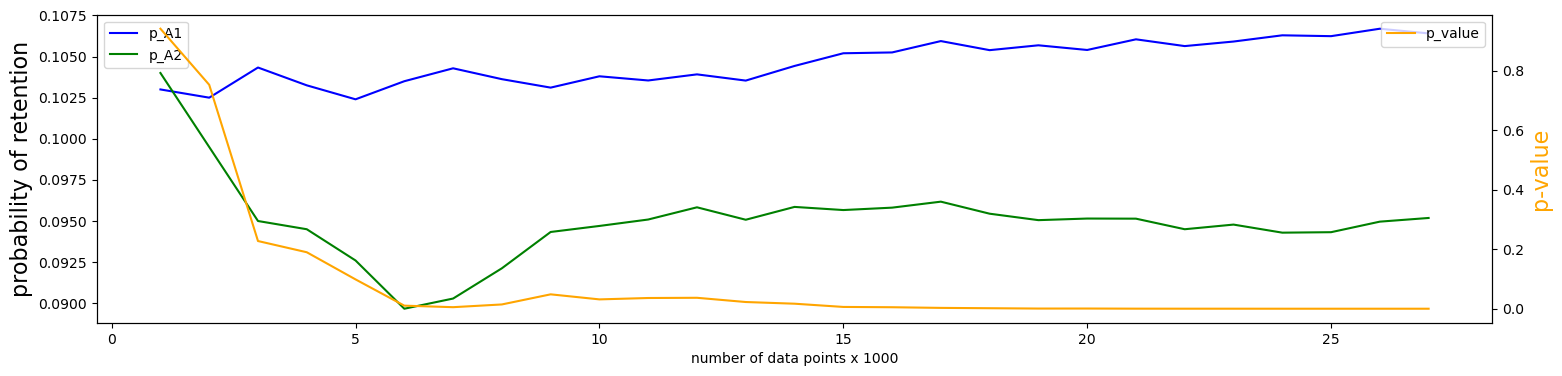

In [33]:
fig,ax = mplt.subplots(1,1,figsize=(18,4))
ax.plot(p_A1,label='p_A1',color='blue')
ax.plot(p_A2,label='p_A2',color='green')
ax.legend()
ax.set_ylabel('probability of retention',fontsize=16)
ax2 = ax.twinx()
ax2.plot(p_value,label='p_value',color='orange')
ax2.legend()
ax2.set_ylabel('p-value',color='orange',fontsize=16);
ax.set_xlabel('number of data points x 1000')

<u>Observation</u> <br>
When the number of observations is lower, p value is highly volatile. As more and more data is collected, p-value, p_A1 and pA2 become stable (so we are safe to make a decision that gate_40 may not be a better alternative to gate_30 however, more data may have to be collected).

<h2>Multi-Arm Bandit</h2>

Suppose instead of 2 options (control and treatment), we have multiple options we want to try at once. In this case, we should allocate equal number of users in each treatment+1 control group. But what if after some some observations, we see that one of the treatment clearly performs very bad. We should not send that treatment to the customers (as it will be a waste to assign your users to something that you clearly are not going to deploy). Also, if it performs really bad, it may hurt your business. Thus, in these cases we can use multi arm bandits to sequentially assign treatments to users. 

NOTE: All the properties of assigning users to different treatment groups, sensitivity of metrics, invariance are still necessary and nothing changes (other than the fact that we have multiple treatment groups).

<h3>Example (slide 47 in Class)</h3>

Suppose in this example, the company wants to check which of the 4 options should be given to new customer (to check whats the % of people who enroll in stitch fix). The company assigns one of the four options to new users sequentially. For example, when a new user checks the website, they will see one of the four options. They could assign it sequentially for days (for example, mondays, assign all users to option A, tuesday : check the performance of all and assign one of option to all users on Wednesday etc).

<img src="stitchfix.png" width="800">
<center>Four Options to select from</center>

<h3>Prior and Posterior</h3>

Prior and posterior are important concepts, particularly in bayesian statistics. For us: <br>
1. Prior: our belief (for example, in the start, we believe that all the four options perform equally good)
2. Posterior: updating our belief(for example, after observing some data, we update our initial belief) <br>


CONCEPT OF MULTI-ARMED- BANDITS: <br>

1. Start with the belief that all options are equally good (if you have other belief, use that belief) <br>
2. Send one of the four options (in this example) to users through <b>selection</b> (we discuss this later) <br>
3. Update the belief based on observing the data <br>
4. Continue until the results converge and one of the four clearly is better than other or you get satisfying results (based on business sense)

<h3>Prior distribution</h3>

In this example, we consider probability of enrolling. Thus we model it is binomial distribution. We use beta distribution as prior as it is the conjugate prior of binomial distribution (we do not discuss conjugate prior here). Consider conjugate prior as a method to update our beliefs after we observe some data. 

Conjugate priors make it easy to update our belief. If beta distribution parameters are (a,b) and data observation is (c,d), we can update our beliefs or posterior as beta distribution with parameters (a+c,b+d): easy to update.

Weak prior: Sometimes we are not sure about our belief as we have not seen enough observations (new products/features). In such cases, we set a weak prior such that the data dictates how the posterior will look like (as posterior is a combination of prior and data).

Strong prior: When we know about the system based on prior experience, we can set strong prior. In such cases, new data updates the prior but prior is strong enough that posterior is not very far from the prior. Examples below:

In [34]:
# Code for showing the examples of prior and posterior distribution 
def prior_posterior():
    fig = plt.figure(figsize=(18, 4))

    A = [4,8,32]
    B = [21,42,168]
    color = ['r','g','b']
    
    # plotting the prior distribution
    plt.subplot(1,2,1)
    for j in range(3):
        a, b = A[j], B[j]
        mean, var, skew, kurt = beta.stats(a, b, moments='mvsk')

        x  = np.linspace(beta.ppf(0.01, a, b),beta.ppf(0.99, a, b), 100)
        rv = beta(a, b)
        plt.plot(x, rv.pdf(x), 'k-', lw=2, label="Beta("+str(A[j])+","+str(B[j])+")",c=color[j])
        plt.axvline(x=A[j]/(A[j]+B[j]),c=color[j])
            
    plt.legend()
    plt.title("Prior Distribution");
    
    # plotting the posterior after 4 failures and 0 success after we collect 4 data points
    plt.subplot(1,2,2)
    for j in range(3):
        a, b = A[j], B[j]+4
        mean, var, skew, kurt = beta.stats(a, b, moments='mvsk')

        x  = np.linspace(beta.ppf(0.01, a, b),beta.ppf(0.99, a, b), 100)
        rv = beta(a, b)
        plt.plot(x, rv.pdf(x), 'k-', lw=2, label="Beta("+str(A[j])+","+str(B[j])+")",c=color[j])
        plt.axvline(x=A[j]/(4+B[j]+A[j]),c=color[j])
        
    plt.legend()
    plt.title("Posterior Distribution");
prior_posterior()

NameError: name 'plt' is not defined

<u>Observation</u> <br>
In left side of the figure above, we consider three prior distributions. The mean of these beta distributions are same (4/21 or 8/42 or 32/168). However, beta distribution with (32,168) is strong prior (as can be seen with the spread of the distribution). The stronger the prior, the lower the spread (and higher the peak).

The right side of the figure above shows how the distribution changes if we observe 4 failures and 0 success (4 people show up in the website and none of them join it). It can be observes that the stronger the prior, the more stable it is (mean does not shift) but for the weaker priors, mean shifts away from 4/21 or 8/42.

Defining what should be the parameters of the prior comes from knowledge of the system and experience. If introducing a new feature, keep the prior weak, so that data will dictate the distribution. If you know the distribution well and are well informed, consider strong prior to avoid surprises in the data (which could be collected due to error in the process).

<h3>Multi Armed Bandit Example</h3>

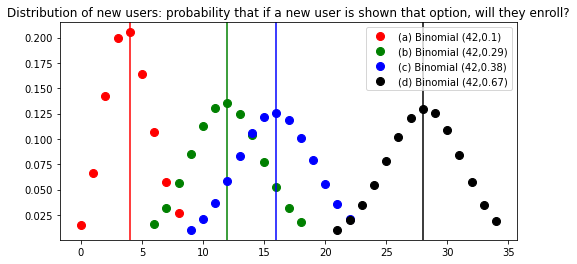

In [184]:
# lets consider that the signup from new users visiting the website comes from 4 different distribution as shown below.
# we deliberately keep value of one distribution higher than the rest of the three.

# Note that these are used drawn for the purpose of drawing from random distribution

fig = plt.figure(figsize=(18, 4))

A = [4,12,16,28]
B = [42]*4
color = ['r','g','b','black']
lab = ['a','b','c','d']

# plotting the prior distribution
plt.subplot(1,2,1)
for j in range(4):
    a, b = A[j], B[j]
    n  = B[j]
    p  = A[j]/B[j]
    x = np.arange(binom.ppf(0.01, n, p),binom.ppf(0.99, n, p))
    mplt.plot(x, binom.pmf(x, n, p), 'o', ms=8, label="("+lab[j]+") Binomial ("+str(42)+","+str(round(p,2))+")",color=color[j])
    mplt.axvline(x=n*p,c=color[j]) 
    
plt.legend()
plt.title("Distribution of new users: probability that if a new user is shown that option, will they enroll?");

<h3>Selection rule for selecting among options to be shown to new users</h3>

<ul>
    <li>First select the prior. Lets consider we select a beta distribution with prior beta (100,30) </li>
    <li>Lets show the four options for 400 new users (100 for each group)</li>
    <li>After 400 users, select the options with highest probability of enrollment (call it optionMax)</li>
    <li>When a new user comes, show them optionMax with probability 1-$\epsilon$, and select among the others randomly with probability $\epsilon$</li>
</ul>

In [192]:
posterior = [[100,30],[100,30],[100,30],[100,30]]
prob      = [30/100]*4

# updating the posterior with 100 users shown the options (400 users are shown the options randomly)
for j in range(4):
    # n = 1 helps in drawing from 0,1, 100 here is the number of users it is shown to
    draw = np.random.binomial(1,A[j]/B[j],100)   
    posterior[j][0] += len(draw)
    posterior[j][1] += sum(draw)
    
    # updating the prob
    prob[j] = posterior[j][1]/posterior[j][0]

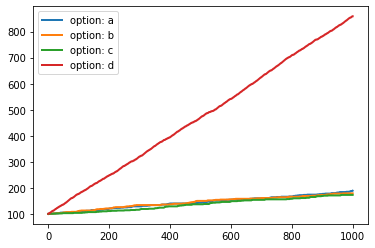

In [211]:
# now that we have shown the options to 100 users, we know something about each option, now we select the options non randomly
# total shown to customers : count 

count = [[100],[100],[100],[100]]

epsilon = 0.25

# lets continue the experiment for 10000 new users
for i in range(1000):
    for j in range(4):
        count[j].append(count[j][-1])
    optMax = np.argmax(prob)
    others = [0,1,2,3]
    others.remove(optMax)
    r = np.random.uniform(0,1)
    
    # select the best based on probability
    if r < 1-epsilon:
        draw = np.random.binomial(1,A[optMax]/B[optMax],1)   # assign one users to option optMax (could assign more)
        posterior[optMax][0] += len(draw)
        posterior[optMax][1] += sum(draw)
        
    # select others randomly
    else:
        optMax = np.random.choice(others)
        draw = np.random.binomial(1,A[optMax]/B[optMax],1)   # assign one users to option optMax (could assign more)
        posterior[optMax][0] += len(draw)
        posterior[optMax][1] += sum(draw)
    
    count[optMax][-1] += 1
    
for j in range(4):
    mplt.plot(count[j],linewidth=2,label='option: '+str(lab[j]))
mplt.legend();

In [212]:
# Netflix has a great section on AB testing in medium:
# check it out for some interesting ways they deal with: https://medium.com/airbnb-engineering/tagged/ab-testing